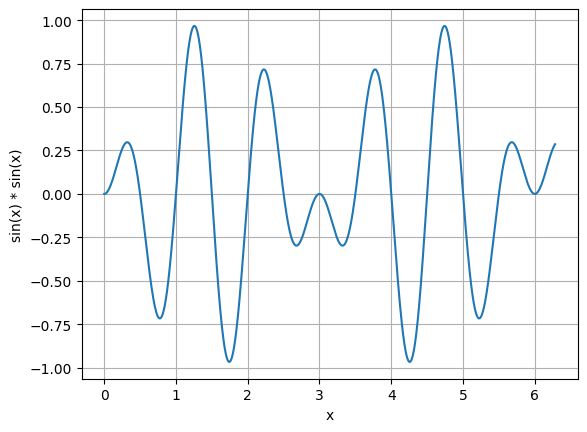

In [202]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import tqdm
# x값의 범위를 생성합니다.

ONEDAY_DATA_LENGTH = 50
INPUT_DAYS = 60
DAYS_OF_ENTIRE_DATASET = 1000
# 0부터 2*pi까지 범위에서 100개의 점을 생성
x = np.linspace(0, 2 * np.pi, ONEDAY_DATA_LENGTH * DAYS_OF_ENTIRE_DATASET)

# y값을 계산합니다.
y = np.sin(x*np.pi*2) * np.sin(x*np.pi/3)  # sin(x) * sin(x) 계산

# 그래프를 그립니다.
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('sin(x) * sin(x)')
plt.grid(True)

# 그래프를 표시합니다.
plt.show()


In [203]:
dataset = np.array(y)
print(dataset.shape)
dataset = dataset.reshape(DAYS_OF_ENTIRE_DATASET, ONEDAY_DATA_LENGTH, 1)
print(dataset.shape)


(50000,)
(1000, 50, 1)


In [204]:
# create dataset
train_x = np.zeros((INPUT_DAYS, ONEDAY_DATA_LENGTH, 1))
train_y = np.zeros((1, ONEDAY_DATA_LENGTH, 1))

print("x and y shape :", train_x.shape, train_y.shape)
for i in range(DAYS_OF_ENTIRE_DATASET - INPUT_DAYS - 1):
    train_x = np.concatenate((train_x, dataset[i:i+60, :, :]), axis=2)
    train_y = np.concatenate((train_y, dataset[np.newaxis, i+61,:]), axis=2)

print("x and y shape :", train_x.shape, train_y.shape)


x and y shape : (60, 50, 1) (1, 50, 1)
x and y shape : (60, 50, 940) (1, 50, 940)


In [205]:

print("Num GPUs Available: ", len(
    tf.config.experimental.list_physical_devices('GPU')))

model = tf.keras.models.Sequential([
    # 1st
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same',
                           strides=1, activation='relu', input_shape=(INPUT_DAYS, ONEDAY_DATA_LENGTH, 1)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', strides=1, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', strides=1, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Reshape((1, 50, 1)),
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()



Num GPUs Available:  0
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 60, 50, 32)        320       
                                                                 
 dropout_51 (Dropout)        (None, 60, 50, 32)        0         
                                                                 
 max_pooling2d_52 (MaxPooli  (None, 30, 25, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_53 (Conv2D)          (None, 30, 25, 64)        18496     
                                                                 
 dropout_52 (Dropout)        (None, 30, 25, 64)        0         
                                                                 
 max_pooling2d_53 (MaxPooli  (None, 15, 12, 64)        0         
 ng2D)                        

In [206]:
history = model.fit(train_x, train_y, epochs=3)
#model.evaluate(new_x_test, y_test, batch_size=32, verbose=2)



ValueError: Data cardinality is ambiguous:
  x sizes: 60
  y sizes: 1
Make sure all arrays contain the same number of samples.

In [ ]:
plt.subplot(221)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.xticks(np.arange(0, 25, 3))
y1 = history.history['loss'][0]+0.3
y2 = history.history['loss'][-1]
#plt.yticks(np.arange(y1, y2, (y2-y1)/5))
plt.xlabel('epochs(times)')
plt.ylabel('loss(%)')
plt.legend(['train', 'test'])
# plt.show()
plt.subplot(222)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid()
plt.xticks(np.arange(0, 25, 3))
yy1 = history.history['accuracy'][0]
yy2 = history.history['accuracy'][-1]+0.2
#plt.yticks(np.arange(yy1, yy2, (yy2-yy1)/5))
plt.xlabel('epochs(times)')
plt.ylabel('accuracy(%)')
plt.legend(['train', 'test'])
plt.show()
